#try the environment with state, action and reward

In [1]:
!pip install gym

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from scipy.stats import norm
import numpy as np

In [2]:
numbers = [1,2,3,4,5,6,7,8,9,10]
np.random.choice(numbers)

4

In [3]:
actions = spaces.Discrete(1001, start=-500)
actions.sample()

226

In [4]:
def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_path, num_period))

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        a_price[:, t + 1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )
    return a_price

In [5]:
def bs_call(iv, T, S, K, r, q):
    
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    
    return bs_price, bs_delta

In [20]:
def get_sim_path(M, freq, np_seed, num_sim):
    """ Return simulated data: a tuple of three arrays
        M: initial time to maturity
        freq: trading freq in unit of day, e.g. freq=2: every 2 day; freq=0.5 twice a day;
        np_seed: numpy random seed
        num_sim: number of simulation path
        1) asset price paths (num_path x num_period)
        2) option price paths (num_path x num_period)
        3) delta (num_path x num_period)
    """
    # set the np random seed
    np.random.seed(np_seed)

    # Trading Freq per day; passed from function parameter
    # freq = 2

    # Annual Trading Day
    T = 252

    # Simulation Time Step
    dt = 0.004 * freq

    # Option Day to Maturity; passed from function parameter
    # M = 60

    # Number of period
    num_period = int(M / freq)

    # Number of simulations; passed from function parameter
    # num_sim = 1000000

    # Annual Return
    mu = 0.05
    
    # Annual Volatility
    vol = 0.2
    
    # Initial Asset Value
    S = 100

    # Option Strike Price
    K = 100

    # Annual Risk Free Rate
    r = 0

    # Annual Dividend
    q = 0

    # asset price 2-d array
    print("1. generate asset price paths")
    a_price = brownian_sim(num_sim, num_period + 1, mu, vol, S, dt)

    # time to maturity "rank 1" array: e.g. [M, M-1, ..., 0]
    ttm = np.arange(M, -freq, -freq)

    # BS price 2-d array and bs delta 2-d array
    print("2. generate BS price and delta")
    bs_price, bs_delta = bs_call(vol, ttm/T, a_price, K, r, q)

    print("simulation done!")

    return a_price, bs_price, bs_delta, ttm

In [31]:
a_price, bs_price, _, ttm = get_sim_path(50,1,1,10)

1. generate asset price paths
2. generate BS price and delta
simulation done!


/home/sauraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
len(ttm)

51

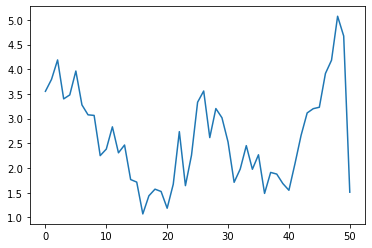

In [38]:
import matplotlib.pyplot as plt
plt.plot(bs_price[2])

In [42]:
class TradingEnv(gym.Env):
    """
    trading environment;
    """

    # trade_freq in unit of day, e.g 2: every 2 day; 0.5 twice a day;
    def __init__(self, cash_flow_flag=0, dg_random_seed=1, num_sim=50, sabr_flag = False,
        continuous_action_flag=False, spread=0, init_ttm=50, trade_freq=1, num_contract=1):

        # simulated data: array of asset price, option price and delta paths (num_path x num_period)
        # generate data now

        self.path, self.option_price_path, self.delta_path,ttm = get_sim_path(M=init_ttm, freq=trade_freq, np_seed=dg_random_seed, 
                                                                          num_sim=num_sim)
        
        # other attributes
        self.num_path = self.path.shape[0]

        # set num_period: initial time to maturity * daily trading freq + 1 (see get_sim_path() in utils.py)
        self.num_period = self.path.shape[1]
        # print("***", self.num_period)

        # time to maturity array
        self.ttm_array = np.arange(init_ttm, -trade_freq, -trade_freq)
        # print(self.ttm_array)

        # spread
        self.spread = spread

        # step function initialization depending on cash_flow_flag
        if cash_flow_flag == 1:
            self.step = self.step_cash_flow
        else:
            self.step = self.step_profit_loss

        self.num_contract = num_contract
        self.strike_price = 100

        # track the index of simulated path in use
        self.sim_episode = -1

        # track time step within an episode (it's step)
        self.t = None
        self.num_action = num_contract * 100 + 1
        self.action_space = spaces.Discrete(self.num_action)

        self.num_state = 3

        self.state = []

        # seed and start
        self.seed()
        # self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # repeatedly go through available simulated paths (if needed)
        self.sim_episode = (self.sim_episode + 1) % self.num_path

        self.t = 0

        price = self.path[self.sim_episode, self.t]
        position = 0

        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        return self.state
    """
    def step_cash_flow(self, action):

        #cash flow period reward


        # do it consistently as in the profit & loss case
        # current prices (at t)
        current_price = self.state[0]

        # current position
        current_position = self.state[1]

        # update time/period
        self.t = self.t + 1

        # get state for tomorrow
        price = self.path[self.sim_episode, self.t]
        position = action
        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        # calculate period reward (part 1)
        cash_flow = -(position - current_position) * current_price - np.abs(position - current_position) * current_price * self.spread

        # if tomorrow is end of episode
        if self.t == self.num_period - 1:
            done = True
            # add (stock payoff + option payoff) to cash flow
            reward = cash_flow + price * position - max(price - self.strike_price, 0) * self.num_contract * 100 - position * price * self.spread
        else:
            done = False
            reward = cash_flow

        # for other info
        info = {"path_row": self.sim_episode}

        return self.state, reward, done, info
        """
        
    def step_profit_loss(self, action):
        """
        profit loss period reward
        """

        # current prices (at t)
        current_price = self.state[0]
        current_option_price = self.option_price_path[self.sim_episode, self.t]

        # current position
        current_position = self.state[1]

        # update time
        self.t = self.t + 1

        # get state for tomorrow (at t + 1)
        price = self.path[self.sim_episode, self.t]
        option_price = self.option_price_path[self.sim_episode, self.t]
        position = action
        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        # calculate period reward (part 1)
        reward = (price - current_price) * position - np.abs(current_position - position) * current_price * self.spread

        # if tomorrow is end of episode
        if self.t == self.num_period - 1:
            done = True
            reward = reward - (max(price - self.strike_price, 0) - current_option_price) * self.num_contract * 100 - position * price * self.spread
        else:
            done = False
            reward = reward - (option_price - current_option_price) * self.num_contract * 100

        # for other info later
        info = {"path_row": self.sim_episode}

        return self.state, reward, done, info

In [43]:
env = TradingEnv()

1. generate asset price paths
2. generate BS price and delta
simulation done!


/home/sauraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
state = env.reset()
state

[100.0, 0, 50]

In [45]:
env.action_space

Discrete(101)

In [48]:
state = env.reset()
for i in range(50):
    # write a function for action like Q-learning or Monte-Carlo
    pervious_state = state
    next_state, reward, done, info = env.step_profit_loss(10)
    state = next_state
    print(next_state, reward, done)

[102.81729040833784, 10, 49] -131.61915771460116 False
[103.40531894147671, 10, 48] -29.065820179336157 False
[103.28679398450562, 10, 47] 10.127428666302478 False
[103.12105835396459, 10, 46] 12.76319686507378 False
[102.97823881925969, 10, 45] 11.46111711722682 False
[103.01327936988116, 10, 44] 1.6539854198096293 False
[101.57377348175976, 10, 43] 79.01705241817027 False
[100.92367941014557, 10, 42] 34.78420292016011 False
[99.67083226350411, 10, 41] 57.84808503517041 False
[99.99699817173395, 10, 40] -9.35747399428223 False
[99.63444324251165, 10, 39] 18.727510907597633 False
[100.27254245725955, 10, 38] -22.32369739368309 False
[100.06320774173136, 10, 37] 12.979781147639784 False
[101.33160195767522, 10, 36] -53.11228770877079 False
[101.61786340364111, 10, 35] -9.917200411601783 False
[104.48565025521032, 10, 34] -159.55821972011222 False
[102.02138668779308, 10, 33] 147.36552878304877 False
[101.20210367610227, 10, 32] 45.44873662708156 False
[102.37500094296827, 10, 31] -55.74